In [90]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import plot_heatmaps

from backtesting.test import SMA, GOOG
import backtesting

import pandas_ta as ta
import talib
import pandas as pd
import time

import numpy as np

import yfinance as yf

import polars as pl

In [92]:
tickers = ['KBANK.BK', "SCC.BK", 'BBL.BK', 'ITD.BK', '7UP.BK', 'SAPPE.BK']
tickers = ['BBL.BK', 'SCC.BK']
ticker = yf.Tickers(tickers=tickers)
df = ticker.history(period='5y', interval='1d')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.sort_index(axis=1, inplace=True)
df

[*********************100%***********************]  2 of 2 completed


Close                    High                     Low  \
                BBL.BK      SCC.BK      BBL.BK      SCC.BK      BBL.BK   
Date                                                                     
2019-02-25  179.609375  400.742828  180.456589  405.794209  178.762161   
2019-02-26  178.762192  397.375275  179.609406  402.426655  177.914978   
2019-02-27  176.220520  397.375275  179.609376  399.059068  175.373306   
2019-02-28  177.067749  399.059082  177.914963  400.742876  175.373321   
2019-03-01  177.067749  394.007660  178.762177  400.742834  177.067749   
...                ...         ...         ...         ...         ...   
2024-02-19  140.500000  264.000000  141.000000  266.000000  140.000000   
2024-02-20  142.000000  264.000000  142.500000  265.000000  141.000000   
2024-02-21  143.500000  268.000000  144.500000  268.000000  143.500000   
2024-02-22  145.000000  273.000000  145.000000  274.000000  143.500000   
2024-02-23  142.500000  271.000000  145.500000  275.000000  142.000000   

                              Open                Volume           
                SCC.BK      BBL.BK      SCC.BK    BBL.BK   SCC.BK  
Date                                                               
2019-02-25  400.742828  179.609375  404.110415   4223600  3049700  
2019-02-26  397.375275  179.609406  400.742862   3251900  3076300  
2019-02-27  395.691481  178.762162  397.375275   6507000  1633300  
2019-02-28  395.691495  176.220535  397.375288   3710800  2454700  
2019-03-01  392.323866  177.914963  399.059040   2165700  2427900  
...                ...         ...         ...       ...      ...  
2024-02-19  262.000000  140.000000  264.000000   2695300  2985300  
2024-02-20  262.000000  141.000000  264.000000   7460200  1400300  
2024-02-21  262.000000  144.000000  264.000000  10317300  3980900  
2024-02-22  268.000000  144.000000  269.000000  10442500  3588900  
2024-02-23  270.000000  145.000000  274.000000  14295200  2410800  

[1213 rows x 10 columns]

In [93]:
df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [94]:
import plotly.express as px
ticker = 'BBL.BK'
plot_df = df.loc[:, (slice(None), ticker)].loc[:, 'Low']
px.line(plot_df)

## select ticker and custom indicators

In [95]:

def get_modeling_df(ticker):
    modeling_df = df.loc[:, (slice(None), ticker)]

    col_index = modeling_df.columns.get_level_values(0)

    modeling_df.columns = col_index
    pattern_df = modeling_df.ta.cdl_pattern(name=["cld_z", 'inside'])

    # momentum
    modeling_df.ta.fisher(append=True)
    modeling_df.ta.rsi(length=8, append=True)
    modeling_df.ta.rsi(length=16, append=True)
    modeling_df.ta.macd(fast=8, slow=21, append=True)
    modeling_df.ta.ao(append=True)
    # modeling_df.ta.obv(append=True)

    # overlap
    modeling_df.ta.ema(append=True)
    modeling_df.ta.fwma(append=True)
    modeling_df.ta.hl2(append=True)

    # statistic
    modeling_df.ta.kurtosis(append=True)
    modeling_df.ta.skew(append=True)
    modeling_df.ta.variance(append=True)

    # Trend
    modeling_df.ta.adx(append=True)
    modeling_df.ta.dpo(append=True)

    # Volatility
    modeling_df.ta.atr(append=True)
    modeling_df.ta.accbands(append=True)
    modeling_df.ta.bbands(length=20, append=True)
    modeling_df.ta.rvi(append=True)

    # Volume
    modeling_df.ta.ad(append=True)
    modeling_df.ta.adosc(append=True)
    modeling_df.ta.cmf(append=True)

    modeling_df['delta_RSI_8-EMA_10'] = modeling_df['RSI_8']-modeling_df['EMA_10']
    cols = modeling_df.columns
    for col in cols:
        concat_df = modeling_df[col]
        for i in range(1, 4):
            # modeling_df[f"{col}_lag{i}"] = modeling_df[col].shift(i)
            temp_df = modeling_df[col].shift(i)
            temp_df.name = f"{col}_lag{i}"
            concat_df = pd.concat([concat_df, temp_df], axis=1)
        modeling_df[f'slope_{col}'] = concat_df.dropna().apply(lambda x: x.pct_change(), axis=1).dropna(axis=1).mean(axis=1)

    modeling_df = modeling_df.join(pattern_df, how='left')

    modeling_df.dropna(inplace=True)
    modeling_df.head()
    return modeling_df

## create target value and drop meta features

In [96]:
concat_df = pd.DataFrame()
for ticker in tickers:
    print(ticker)
    modeling_df = get_modeling_df(ticker)
    modeling_df['is_higher'] = modeling_df['Close'].shift(-14)>modeling_df['Close']
    # modeling_df['is_higher'] = modeling_df['Close'].pct_change(-1)
    modeling_df.dropna(inplace=True)
    modeling_df.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

    concat_df = pd.concat([modeling_df, concat_df], axis=0)
# modeling_df['is_higher'].hist()

BBL.BK
[X] There is no candle pattern named cld_z available!
SCC.BK
[X] There is no candle pattern named cld_z available!


In [97]:
concat_df.is_higher.value_counts()

False    1329
True     1003
Name: is_higher, dtype: int64

In [119]:
concat_df.columns

Index(['FISHERT_9_1', 'FISHERTs_9_1', 'RSI_8', 'RSI_16', 'MACD_8_21_9',
       'MACDh_8_21_9', 'MACDs_8_21_9', 'AO_5_34', 'EMA_10', 'FWMA_10', 'HL2',
       'KURT_30', 'SKEW_30', 'VAR_30', 'ADX_14', 'DMP_14', 'DMN_14', 'DPO_20',
       'ATRr_14', 'ACCBL_20', 'ACCBM_20', 'ACCBU_20', 'BBL_20_2.0',
       'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'RVI_14', 'AD',
       'ADOSC_3_10', 'CMF_20', 'delta_RSI_8-EMA_10', 'slope_Close',
       'slope_High', 'slope_Low', 'slope_Open', 'slope_Volume',
       'slope_FISHERT_9_1', 'slope_FISHERTs_9_1', 'slope_RSI_8',
       'slope_RSI_16', 'slope_MACD_8_21_9', 'slope_MACDh_8_21_9',
       'slope_MACDs_8_21_9', 'slope_AO_5_34', 'slope_EMA_10', 'slope_FWMA_10',
       'slope_HL2', 'slope_KURT_30', 'slope_SKEW_30', 'slope_VAR_30',
       'slope_ADX_14', 'slope_DMP_14', 'slope_DMN_14', 'slope_DPO_20',
       'slope_ATRr_14', 'slope_ACCBL_20', 'slope_ACCBM_20', 'slope_ACCBU_20',
       'slope_BBL_20_2.0', 'slope_BBM_20_2.0', 'slope_BBU_20_2.

# Pycaret

In [121]:
from pycaret.classification import *
# from pycaret.regression import *

s = setup(
    modeling_df,
    target = 'is_higher',
    session_id = 123,
    fold_strategy = 'timeseries',
    fold=3,
    data_split_shuffle=False,
    data_split_stratify=False,
    # fix_imbalance=True,
    create_date_columns=['month', 'day_of_week', 'year', 'day'],
    polynomial_features=False,
    polynomial_degree=2,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.85,
    use_gpu=True,
    feature_selection=True,
    feature_selection_estimator='lightgbm',
    pca=False,
    normalize=True,
    )

,Description,Value
0,Session id,123
1,Target,is_higher
2,Target type,Binary
3,Original data shape,"(1166, 71)"
4,Transformed data shape,"(1166, 15)"
5,Transformed train set shape,"(816, 15)"
6,Transformed test set shape,"(350, 15)"
7,Numeric features,70
8,Preprocess,1
9,Imputation type,simple


In [122]:
s.train_transformed

,KURT_30,DMP_14,DPO_20,ATRr_14,BBU_20_2.0,AD,ADOSC_3_10,CMF_20,delta_RSI_8-EMA_10,slope_MACDh_8_21_9,slope_DMN_14,slope_DPO_20,slope_ATRr_14,slope_BBU_20_2.0,is_higher
Date,,,,,,,,,,,,,,,
2019-04-19,-0.455411,-0.863558,-0.180138,-0.453527,1.544166,1.625615,-0.830357,0.102098,-1.590806,0.056052,0.828757,0.390212,0.896979,-0.181782,False
2019-04-22,-0.470206,-0.991461,-0.333122,-0.460715,1.555052,1.584217,-1.043041,0.025488,-1.643091,0.049099,0.339597,0.078222,0.833520,-0.207563,True
2019-04-23,-0.321387,-1.142991,-0.778154,-0.401732,1.574834,1.559753,-1.178153,0.012318,-1.744453,0.029182,-0.684045,0.077023,0.090746,-0.269985,True
2019-04-24,-0.452052,-1.216373,-0.402659,-0.478278,1.567597,1.613485,-0.725261,-0.001776,-1.561955,0.033584,-0.688277,0.088543,0.084200,-0.192790,True
2019-04-25,-0.638150,-0.637245,-0.360938,-0.549356,1.561074,1.587231,-0.629432,-0.300036,-1.542858,0.056091,-0.313476,0.120711,0.435752,-0.082255,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-29,-0.442906,-0.888240,-0.125030,-1.454807,-0.140334,-1.442295,0.274117,0.300417,-0.497658,-0.013098,-0.614644,-0.325606,0.797536,0.164752,False
2022-08-30,-0.658394,-0.687991,0.194333,-1.512061,-0.139245,-1.442295,0.270446,0.572101,-0.351001,0.012568,-0.602801,-0.217154,0.762293,0.106869,False
2022-08-31,-0.798415,-0.770148,0.226273,-1.565225,-0.139034,-1.505868,-0.170640,0.524560,-0.423129,-0.034100,-0.591066,-0.184383,0.727465,0.070457,False


In [ ]:
s.get_config()

In [134]:
model = s.create_model(estimator='lr')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:39:49
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6078,0.7166,0.3950,0.8545,0.5402,0.2716,0.3342
1,0.6961,0.8251,0.3678,0.8205,0.5079,0.3314,0.3874
2,0.7647,0.8237,0.5412,0.8364,0.6571,0.4903,0.5172
Mean,0.6895,0.7885,0.4347,0.8371,0.5684,0.3644,0.4129
Std,0.0642,0.0509,0.0761,0.0139,0.0641,0.0923,0.0769


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [123]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6895,0.7885,0.4347,0.8371,0.5684,0.3644,0.4129,0.2200
svm,SVM - Linear Kernel,0.6781,0.0000,0.5111,0.6977,0.5827,0.3175,0.3313,0.1933
ridge,Ridge Classifier,0.6732,0.0000,0.3687,0.8815,0.5188,0.3293,0.3996,0.1900
lda,Linear Discriminant Analysis,0.6716,0.7863,0.3559,0.8978,0.5074,0.3221,0.3994,0.2000
et,Extra Trees Classifier,0.6307,0.7144,0.5648,0.6527,0.5658,0.2829,0.3091,0.2367
lightgbm,Light Gradient Boosting Machine,0.6291,0.7412,0.5295,0.6647,0.5555,0.2685,0.2916,0.3267
rf,Random Forest Classifier,0.6193,0.7172,0.5673,0.6185,0.5662,0.2607,0.2704,0.2633
gbc,Gradient Boosting Classifier,0.6193,0.7142,0.4652,0.6605,0.5088,0.2558,0.2736,0.2900
xgboost,Extreme Gradient Boosting,0.6160,0.6990,0.4720,0.6619,0.5201,0.2406,0.2606,0.3033
dt,Decision Tree Classifier,0.6144,0.6046,0.4144,0.6581,0.5023,0.2143,0.2306,0.2033


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [132]:
best

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []


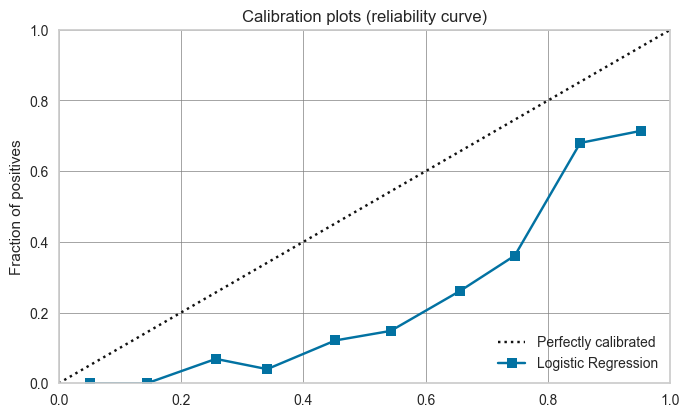

In [135]:
plot_model(model, plot = 'calibration')

In [136]:
s.interpret_model(model, plot='summary')

TypeError: This function only supports tree based models for binary classification: et, lightgbm, dt, rf, xgboost.

In [137]:
dashboard(model)

Note: model_output='probability' is currently not supported for linear classifiers models with shap. So defaulting to model_output='logodds' If you really need probability outputs use shap='kernel' instead.
Note: shap values for shap='linear' get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.LinearExplainer(model, X)...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Ca

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

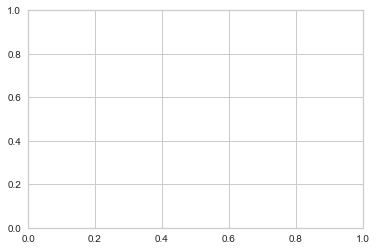

In [138]:
s.evaluate_model(model)

In [77]:
# predict new stock with different model trained stock
ticker_new = 'KBANK.BK'

new_df = get_modeling_df(ticker_new)
new_df.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
new_df.head()

[X] There is no candle pattern named cld_z available!


,FISHERT_9_1,FISHERTs_9_1,RSI_8,RSI_16,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,AO_5_34,EMA_10,FWMA_10,...,slope_BBM_20_2.0,slope_BBU_20_2.0,slope_BBB_20_2.0,slope_BBP_20_2.0,slope_RVI_14,slope_AD,slope_ADOSC_3_10,slope_CMF_20,slope_delta_RSI_8-EMA_10,CDL_INSIDE
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-19,-1.242492,-1.319225,36.183064,41.494846,-2.907217,-2.390893,-0.516324,-6.789632,398.749810,395.585758,...,0.000923,-0.000554,-0.050925,-0.355445,0.021098,-0.094437,0.022077,-3.152250,0.008342,0
2019-04-22,-1.181144,-1.242492,33.235875,39.768183,-3.242895,-2.181256,-1.061638,-6.203953,397.748773,394.649098,...,0.000996,-0.000658,-0.054167,0.102278,0.207034,-0.241837,-0.085698,-0.673464,-0.002479,0
2019-04-23,-1.401849,-1.181144,28.019219,36.525668,-3.865722,-2.243267,-1.622455,-6.056709,396.305293,392.751739,...,0.001141,-0.000909,-0.062178,0.373115,0.208279,-0.187398,-0.103045,-0.252409,-0.004421,0
2019-04-24,-1.743993,-1.401849,33.943886,39.170879,-4.002511,-1.904045,-2.098466,-7.110533,395.436492,392.235379,...,0.001424,-0.000598,-0.058757,0.242424,0.084773,0.006072,0.063997,-0.091709,0.001070,1
2019-04-25,-1.451073,-1.743993,33.943886,39.170879,-4.018372,-1.535924,-2.482447,-7.725435,394.725654,391.923161,...,0.001707,-0.000153,-0.051813,0.104755,-0.023128,0.036242,0.151160,-0.165586,0.003506,0


[X] There is no candle pattern named cld_z available!


,FISHERT_9_1,FISHERTs_9_1,RSI_8,RSI_16,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,AO_5_34,EMA_10,FWMA_10,...,slope_BBM_20_2.0,slope_BBU_20_2.0,slope_BBB_20_2.0,slope_BBP_20_2.0,slope_RVI_14,slope_AD,slope_ADOSC_3_10,slope_CMF_20,slope_delta_RSI_8-EMA_10,CDL_INSIDE
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-19,2.471672,2.183211,53.901505,49.847660,0.885412,0.861861,0.023551,2.140310,167.826891,168.845173,...,-0.001404,-0.002851,-0.056753,0.128248,0.043536,0.201044,-0.233063,-4.743329,-0.039750,0
2019-04-22,2.217037,2.471672,56.212803,51.087370,0.850296,0.661396,0.188900,2.292601,167.944852,168.714568,...,-0.001096,-0.002213,-0.042079,0.111264,0.037984,0.064925,0.082898,-1.756546,-0.038031,0
2019-04-23,1.851063,2.217037,60.714939,53.537506,0.924418,0.588414,0.336004,2.393691,168.202160,168.973862,...,-0.000745,-0.001383,-0.023086,0.106304,0.035629,-0.060973,0.201792,-1.877940,-0.040888,0
2019-04-24,1.904354,1.851063,66.601902,56.985150,1.132353,0.637079,0.495274,2.556623,168.653885,169.647641,...,-0.000836,-0.001940,-0.038136,-0.079379,-0.057773,0.459131,-0.027998,0.050636,0.037460,0
2019-04-25,2.154008,1.904354,66.601902,56.985150,1.256501,0.608982,0.647519,2.712219,169.023478,170.052729,...,-0.001142,-0.002513,-0.045787,-0.048309,-0.031680,0.459131,-0.144417,-0.439276,0.029714,0


In [78]:
# predict model on new_data
predictions = s.predict_model(model, data = new_df)
predictions.head()

ValueError: Input X contains infinity or a value too large for dtype('float64').

<AxesSubplot:>

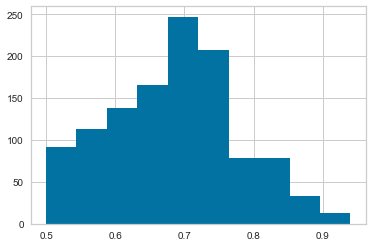

Empty DataFrame
Columns: [col, contribution, value]
Index: []Empty DataFrame
Columns: [col, contribution, value]
Index: []

Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []


In [66]:
predictions.prediction_score.hist()

# save mopdel

In [42]:
# save pipeline
s.save_model(best, 'my_first_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['FISHERT_9_1', 'FISHERTs_9_1',
                                              'RSI_8', 'RSI_16', 'MACD_8_21_9',
                                              'MACDh_8_21_9', 'MACDs_8_21_9',
                                              'AO_5_34', 'OBV', 'EMA_10',
                                              'FWMA_10', 'HL2', 'KURT_30',
                                              'SKEW_30', 'VAR_30', 'ADX_14',
                                              'DMP_14', 'DMN_14', 'DPO_20',
                                              'ATRr_14', 'ACCBL_20', 'ACCBM_20',
                                              'ACCBU_20', 'BBL...
                                                                 norm_order=1,
                                                                 prefit=False,
                            

In [46]:
s.pipeline

Pipeline(memory=FastMemory(location=/var/folders/bw/kfpk0f251ld170_k61dkg75m0000gn/T/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['FISHERT_9_1', 'FISHERTs_9_1',
                                             'RSI_8', 'RSI_16', 'MACD_8_21_9',
                                             'MACDh_8_21_9', 'MACDs_8_21_9',
                                             'AO_5_34', 'OBV', 'EMA_10',
                                             'FWMA_10', 'HL2', 'KURT_30',
                                             'SKEW_30', 'VAR_30', 'ADX_14',
                                             'DMP_14', 'DMN_14', '...
                                                                                         random_state=None,
                                                                                         reg_alpha=0.0,
                                                                                         reg_lambda=0.0,
                                                                                         silent='warn',
                                                                                         subsample=1.0,
                                                                                         subsample_for_bin=200000,
                                                                                         subsample_freq=0),
                                                                importance_getter='auto',
                                                                max_features=14,
                                                                norm_order=1,
                                                                prefit=False,
                                                                threshold=-inf))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

In [30]:
from sktime.transformations.hierarchical.aggregate import Aggregator
from sktime.utils._testing.hierarchical import _bottom_hier_datagen
agg = Aggregator()
y_ = _bottom_hier_datagen(
    no_bottom_nodes=6,
    no_levels=3,
    random_seed=123,
)
y = agg.fit_transform(y_)

In [54]:
y_

passengers
l3_agg    l2_agg    l1_agg    timepoints             
l3_node01 l2_node01 l1_node01 1949-01      112.000000
                              1949-02      118.000000
                              1949-03      132.000000
                              1949-04      129.000000
                              1949-05      121.000000
...                                               ...
          l2_node03 l1_node05 1960-08     3258.902341
                              1960-09     2733.580777
                              1960-10     2481.639418
                              1960-11     2101.044968
                              1960-12     2326.185692

[864 rows x 1 columns]

In [51]:
y

passengers
l3_agg    l2_agg    l1_agg    timepoints             
__total   __total   __total   1949-01     6528.548301
                              1949-02     6888.936278
                              1949-03     7735.438913
                              1949-04     7553.385782
                              1949-05     7069.670000
...                                               ...
l3_node01 l2_node03 l1_node05 1960-08     3258.902341
                              1960-09     2733.580777
                              1960-10     2481.639418
                              1960-11     2101.044968
                              1960-12     2326.185692

[1296 rows x 1 columns]

In [57]:
level_0_values = y.index.get_level_values(0)

# Get level 1 values
level_1_values = y.index.get_level_values(1)
level_2_values = y.index.get_level_values(2)

# Combine levels if needed
new_index = pd.MultiIndex.from_tuples(zip(level_0_values, level_1_values, level_2_values))

# Set as index
# new_df = df.set_index(new_index)
# new_df.head()
new_index.unique()

MultiIndex([(  '__total',   '__total',   '__total'),
            ('l3_node01', 'l2_node01',   '__total'),
            ('l3_node01', 'l2_node01', 'l1_node01'),
            ('l3_node01', 'l2_node01', 'l1_node04'),
            ('l3_node01', 'l2_node01', 'l1_node06'),
            ('l3_node01', 'l2_node02', 'l1_node03'),
            ('l3_node01', 'l2_node03',   '__total'),
            ('l3_node01', 'l2_node03', 'l1_node02'),
            ('l3_node01', 'l2_node03', 'l1_node05')],
           )

In [118]:
import sktime 